In [6]:
import geopandas as gpd
import rioxarray as rio
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from tqdm.notebook import tqdm
import os
import pandas as pd

In [7]:
#Load the crown polygons
crowns = gpd.read_file('data/tree_crowns.gpkg')

#Remove spaces at the end of the common name
crowns['common_name'] = crowns['common_name'].str.strip()

print(crowns['common_name'].value_counts())

#Select top three speceis
target_species = crowns['common_name'].value_counts().head(4).index.tolist()
print(target_species)

#Reduce the dataset to only the top three species
crowns = crowns[crowns['common_name'].isin(target_species)]

#Classify species into conniferous or deciduous
deciduous = ['Paper birch', 'Red maple']
coniferous = ['Balsam fir', 'Eastern white cedar']
crowns['species_type'] = None
crowns.loc[crowns['common_name'].isin(deciduous), 'species_type'] = 'deciduous'
crowns.loc[crowns['common_name'].isin(coniferous), 'species_type'] = 'coniferous'

#Randomly sample crowns from each species
crowns = crowns.groupby('common_name').apply(lambda x: x.sample(150, random_state=11), include_groups=True).reset_index(drop=True)

print("\nReduced sample:")
print(crowns['common_name'].value_counts())
print(crowns['species_type'].value_counts())


common_name
Paper birch            2692
Red maple              2361
Balsam fir             1438
Eastern white cedar     886
Sugar maple             424
Dead tree               409
Spruce                  398
White pine              227
Striped maple           195
Tamarack                181
Yellow birch            174
American beach           59
Eastern hemlock          51
Aspen                     3
Name: count, dtype: int64
['Paper birch', 'Red maple', 'Balsam fir', 'Eastern white cedar']

Reduced sample:
common_name
Balsam fir             150
Eastern white cedar    150
Paper birch            150
Red maple              150
Name: count, dtype: int64
species_type
coniferous    300
deciduous     300
Name: count, dtype: int64


C:\Users\hseely\AppData\Local\Temp\ipykernel_31328\3870495958.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crowns = crowns.groupby('common_name').apply(lambda x: x.sample(150, random_state=11), include_groups=True).reset_index(drop=True)


In [8]:
crowns

label common_name  scientific_name          genus  crown_id  \
0    ABBA  Balsam fir   Abies balsamea      Pinaceae       8340   
1    ABBA  Balsam fir   Abies balsamea      Pinaceae       9399   
2    ABBA  Balsam fir   Abies balsamea      Pinaceae       2458   
3    ABBA  Balsam fir   Abies balsamea      Pinaceae       2492   
4    ABBA  Balsam fir   Abies balsamea      Pinaceae        567   
..    ...         ...              ...            ...       ...   
595  ACRU   Red maple     Acer rubrum    Sapindaceae         54   
596  ACRU   Red maple     Acer rubrum    Sapindaceae       1327   
597  ACRU   Red maple     Acer rubrum    Sapindaceae       6126   
598  ACRU   Red maple     Acer rubrum    Sapindaceae       5284   
599  ACRU   Red maple     Acer rubrum    Sapindaceae       6506   

                                              geometry species_type  
0    MULTIPOLYGON (((577191.446 5093488.217, 577191...   coniferous  
1    MULTIPOLYGON (((576958.412 5093313.133, 576958...   coniferous  
2    MULTIPOLYGON (((577066.056 5093338.765, 577065...   coniferous  
3    MULTIPOLYGON (((577054.098 5093354.535, 577054...   coniferous  
4    MULTIPOLYGON (((577190.923 5093217.595, 577190...   coniferous  
..                                                 ...          ...  
595  MULTIPOLYGON (((577090.925 5093119.305, 577090...    deciduous  
596  MULTIPOLYGON (((577076.149 5093308.862, 577076...    deciduous  
597  MULTIPOLYGON (((577310.509 5093634.769, 577310...    deciduous  
598  MULTIPOLYGON (((577448.862 5093588.134, 577448...    deciduous  
599  MULTIPOLYGON (((577318.737 5093475.773, 577318...    deciduous  

[600 rows x 7 columns]

<Axes: >

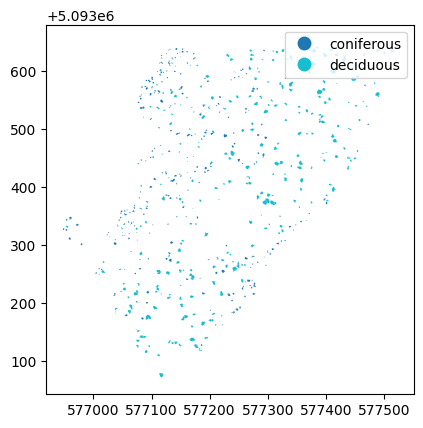

In [9]:
crowns.plot(column="species_type", legend=True)

In [10]:
#Add a new columns for bounding box coords for each crown
for bound in ['minx', 'miny', 'maxx', 'maxy']:
    crowns[bound] = crowns.bounds[bound]

crowns

label common_name  scientific_name          genus  crown_id  \
0    ABBA  Balsam fir   Abies balsamea      Pinaceae       8340   
1    ABBA  Balsam fir   Abies balsamea      Pinaceae       9399   
2    ABBA  Balsam fir   Abies balsamea      Pinaceae       2458   
3    ABBA  Balsam fir   Abies balsamea      Pinaceae       2492   
4    ABBA  Balsam fir   Abies balsamea      Pinaceae        567   
..    ...         ...              ...            ...       ...   
595  ACRU   Red maple     Acer rubrum    Sapindaceae         54   
596  ACRU   Red maple     Acer rubrum    Sapindaceae       1327   
597  ACRU   Red maple     Acer rubrum    Sapindaceae       6126   
598  ACRU   Red maple     Acer rubrum    Sapindaceae       5284   
599  ACRU   Red maple     Acer rubrum    Sapindaceae       6506   

                                              geometry species_type  \
0    MULTIPOLYGON (((577191.446 5093488.217, 577191...   coniferous   
1    MULTIPOLYGON (((576958.412 5093313.133, 576958...   coniferous   
2    MULTIPOLYGON (((577066.056 5093338.765, 577065...   coniferous   
3    MULTIPOLYGON (((577054.098 5093354.535, 577054...   coniferous   
4    MULTIPOLYGON (((577190.923 5093217.595, 577190...   coniferous   
..                                                 ...          ...   
595  MULTIPOLYGON (((577090.925 5093119.305, 577090...    deciduous   
596  MULTIPOLYGON (((577076.149 5093308.862, 577076...    deciduous   
597  MULTIPOLYGON (((577310.509 5093634.769, 577310...    deciduous   
598  MULTIPOLYGON (((577448.862 5093588.134, 577448...    deciduous   
599  MULTIPOLYGON (((577318.737 5093475.773, 577318...    deciduous   

            minx          miny         maxx          maxy  
0    577189.0365  5.093486e+06  577192.0568  5.093488e+06  
1    576957.3289  5.093309e+06  576960.9351  5.093313e+06  
2    577064.1428  5.093336e+06  577066.9213  5.093339e+06  
3    577052.4109  5.093352e+06  577054.2873  5.093355e+06  
4    577186.6727  5.093215e+06  577191.7753  5.093218e+06  
..           ...           ...          ...           ...  
595  577088.2029  5.093114e+06  577093.3687  5.093119e+06  
596  577074.5608  5.093307e+06  577076.5100  5.093309e+06  
597  577308.0109  5.093633e+06  577310.8445  5.093635e+06  
598  577443.5990  5.093582e+06  577452.3151  5.093589e+06  
599  577315.9984  5.093473e+06  577319.4037  5.093477e+06  

[600 rows x 11 columns]

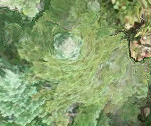

In [11]:
#Load the orthophoto
ortho = rio.open_rasterio('data/2021-08-18-sbl-z1-rgb-cog.tif')

#Load all crowns for each sp type into a dict
def clip_crown_from_ras(ortho, crown, target_res=None):

    #Clip the orthophoto to the crown bounding box
    crown_ras = ortho.rio.clip_box(minx=crown['minx'], 
                                    miny=crown['miny'], 
                                    maxx=crown['maxx'], 
                                    maxy=crown['maxy'])
    
    #Extract numpy array from rioxarray
    crown_ras = crown_ras.values

    #todo: find a way to keep the NIR band
    #Drop the NIR band (4)
    crown_ras = crown_ras[:3]

    #Convert to PIL image
    crown_ras = Image.fromarray(crown_ras.transpose(1,2,0))
    
    #Rescale image to target resolution
    if target_res is not None:

        rescale_img = transforms.Compose([transforms.Resize((target_res, target_res))])

        crown_ras = rescale_img(crown_ras)
        
    return crown_ras

clip_crown_from_ras(ortho, crowns.iloc[0], target_res=None)


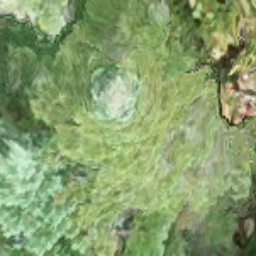

In [12]:
clip_crown_from_ras(ortho, crowns.iloc[0], target_res=256)

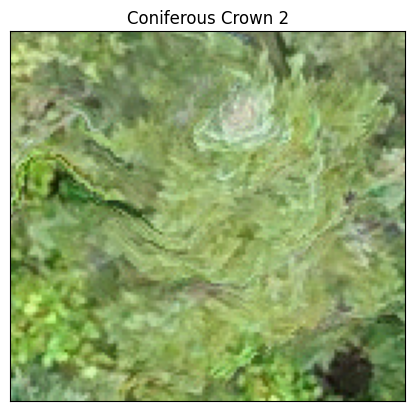

In [13]:
def plot_crown(ortho, crown_df, crown_id, ax=None, target_res=None):

    if ax is None:
        _, ax = plt.subplots()

    crown = crown_df.loc[crown_id]

    crown_img = clip_crown_from_ras(ortho, crown, target_res)
    
    ax.imshow(crown_img)

    #Add title to the plot showing species name and crown id
    ax.set_title(f"{crown['species_type']} Crown {crown_id}".title())

    #Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

plot_crown(ortho, crowns, crown_id=2)

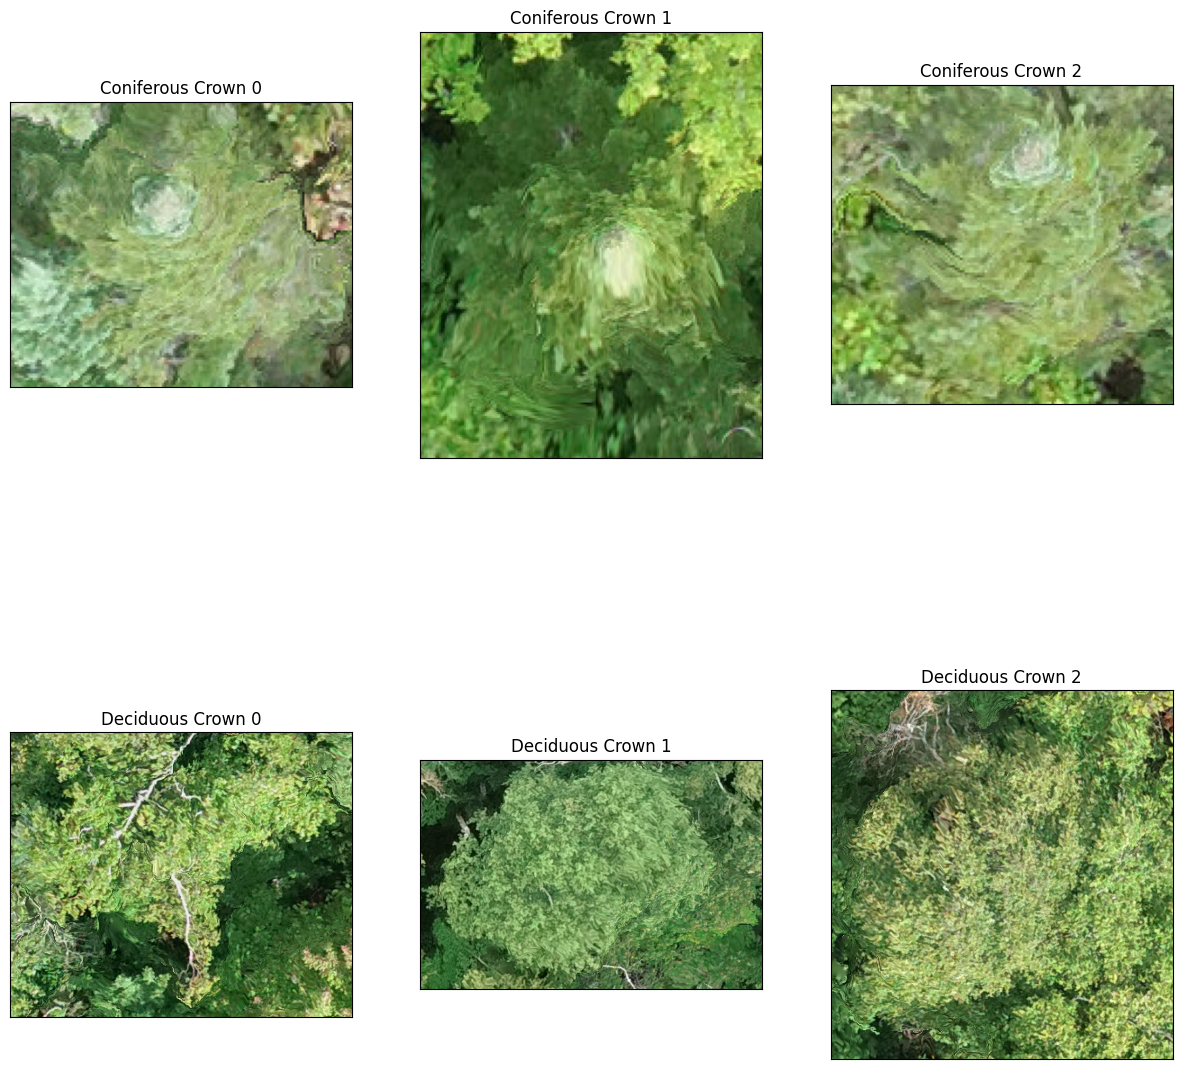

In [14]:
#Plot a grid of each tree species showing example crowns
fig, axs = plt.subplots(2, 3, figsize=(15, 15))

for row, sp in enumerate(crowns['species_type'].unique()):

    crowns_sp_sub = crowns[crowns['species_type'] == sp].reset_index(drop=True)

    for col in range(3):

        plot_crown(ortho, 
                   crowns_sp_sub, 
                   col,
                   ax=axs[row, col])


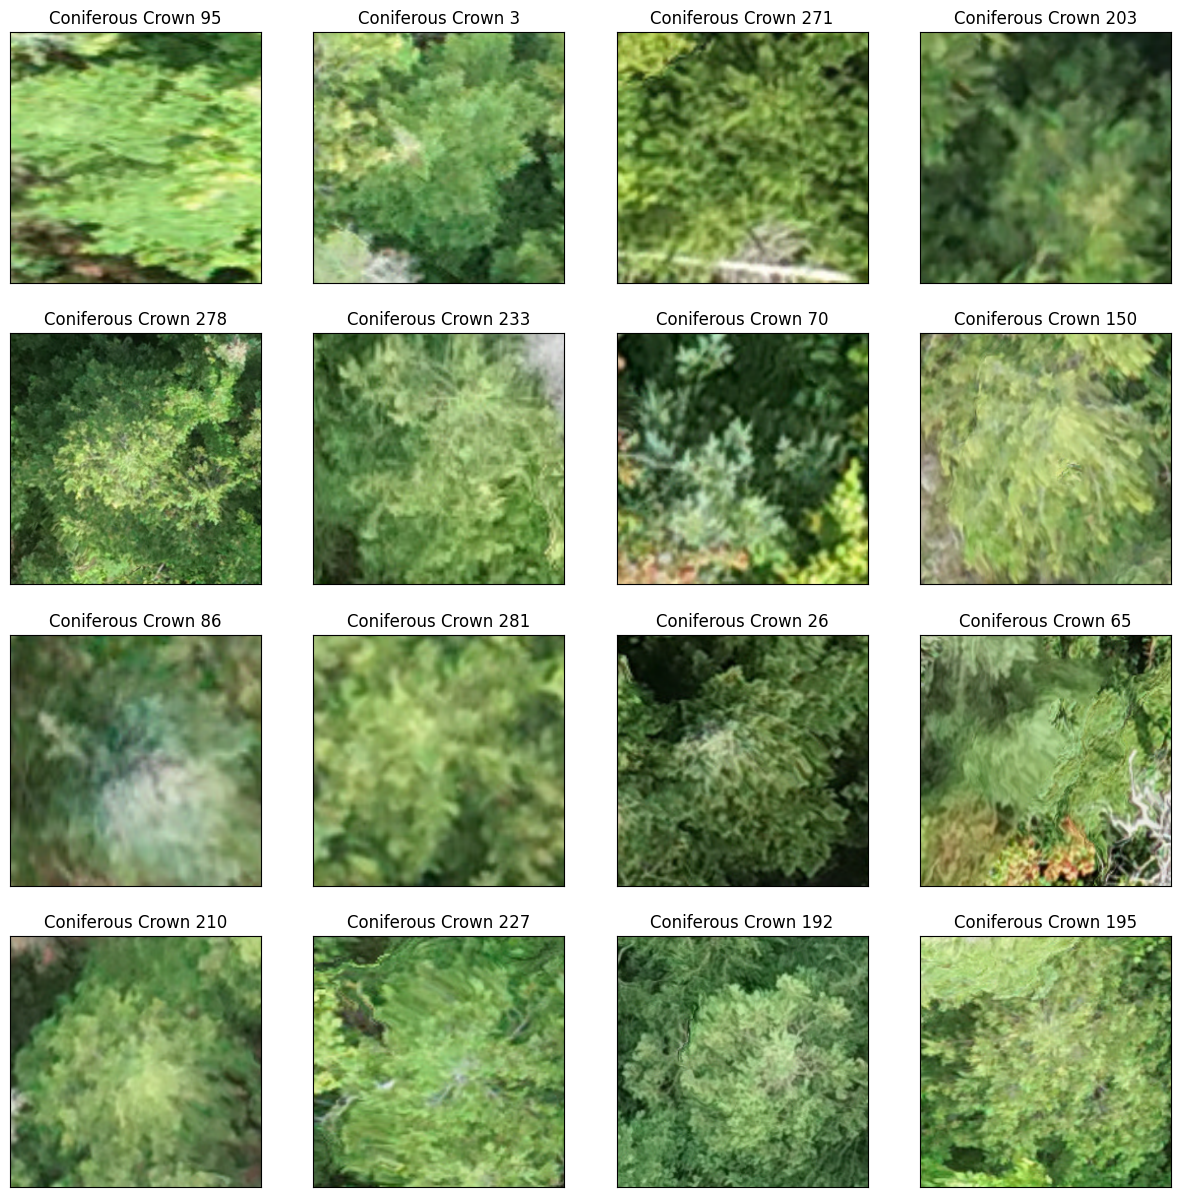

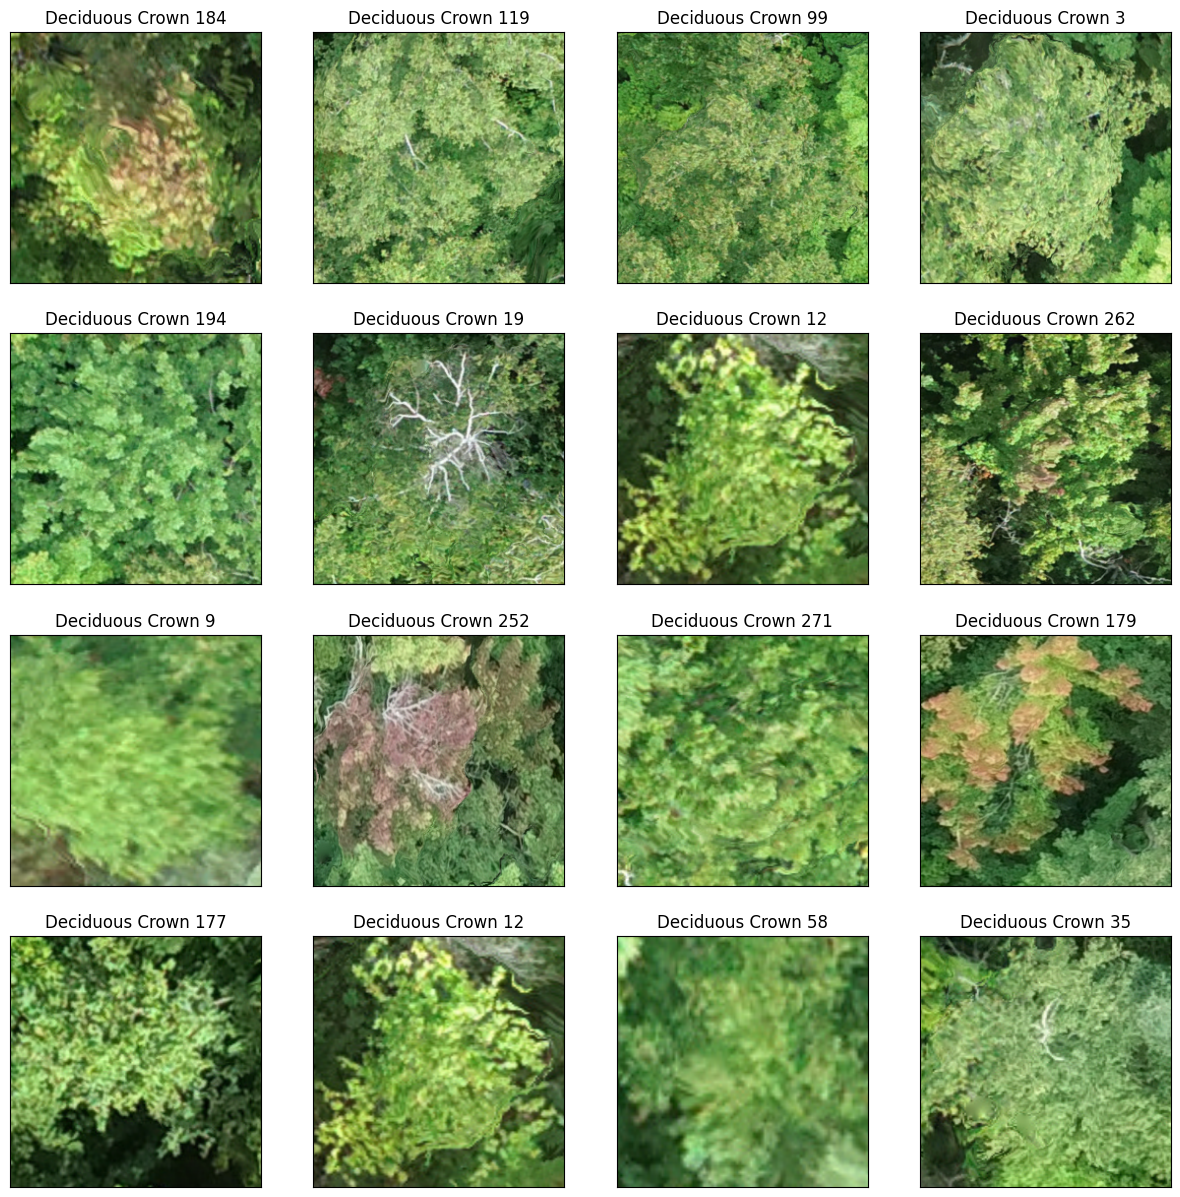

In [15]:
import numpy as np
#Plot a grid of the same trees with 256x256 pixel resolution
#We need all images to be same dimensions to work in CNN

CLASSES = crowns['species_type'].unique()

n_grid_cell = 4

for c in CLASSES:

    fig, axs = plt.subplots(n_grid_cell, n_grid_cell, figsize=(15, 15))

    crowns_sp_sub = crowns[crowns['species_type'] == c].reset_index(drop=True)

    for row in range(n_grid_cell):

        for col in range(n_grid_cell):

            plot_crown(ortho=ortho, 
                        crown_df=crowns_sp_sub, 
                        crown_id=np.random.randint(0, len(crowns_sp_sub)),
                        ax=axs[row, col],
                        target_res=256)

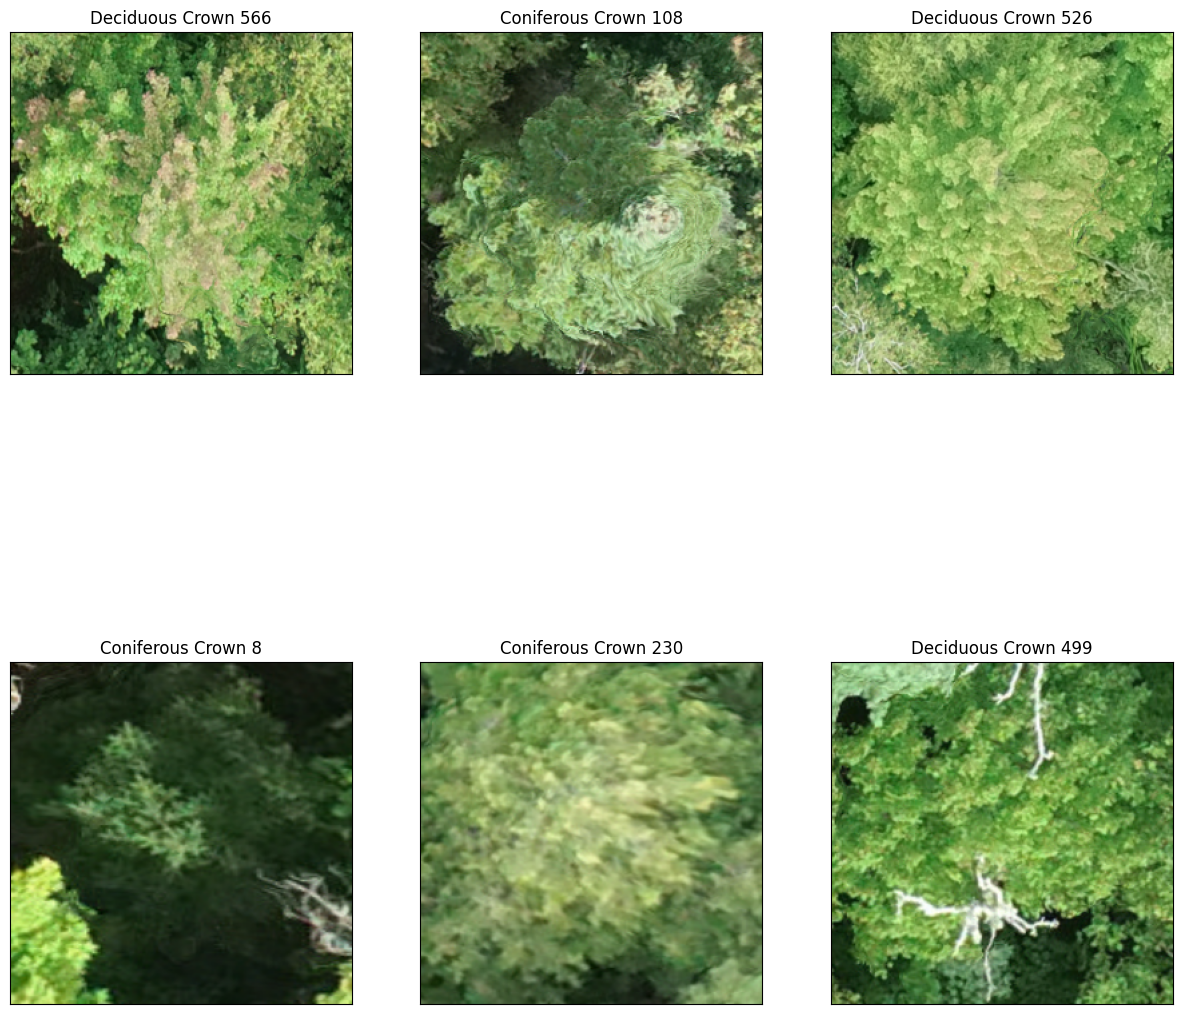

In [29]:
#Plot a mix of coniferous and deciduous trees

import numpy as np
#Plot a grid of the same trees with 256x256 pixel resolution
#We need all images to be same dimensions to work in CNN


fig, axs = plt.subplots(2, 3, figsize=(15, 15))

for row in range(2):

    for col in range(3):

        rand_crown_id = np.random.randint(0, len(crowns))

        plot_crown(ortho=ortho, 
                    crown_df=crowns, 
                    crown_id=rand_crown_id,
                    ax=axs[row, col],
                    target_res=256)

In [ ]:
#Export the updated crowns 
crowns.to_file('data/tree_crowns_subset.gpkg', driver='GPKG')

#Remove existing images
ls_existing = os.listdir('data/clipped_crowns')
for f in tqdm(ls_existing, desc='Removing existing images'):
    os.remove(f'data/clipped_crowns/{f}')

#Export images to folder
for id in tqdm(crowns['crown_id'], desc='Exporting images'):

    crown = crowns[crowns['crown_id'] == id]

    crown_img = clip_crown_from_ras(ortho, crown, target_res=256)

    crown_img.save(f'data/clipped_crowns/crown_{crown["crown_id"].values[0]}.png')